In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import re 
from utils import * 
import itertools 
from tqdm import tqdm 
import warnings 
import subprocess
import os 
from src.ggkbase import * 
import glob
import matplotlib as mpl 
from src.files import BLASTFileJSON, FASTAFile, InterProScanFileTSV, GenBankFile, fasta_get_genome_size
from src.metat import * 
import json
from Bio import Align
from Bio.Seq import Seq
import itertools
import scipy
import sklearn
import requests
from src.kegg import *

%load_ext autoreload
%autoreload 2



In [2]:
ece_id = 'ece_26_1334'

def filter_low_counts(metat_df, min_count:int=5, min_samples:int=3):
    '''Remove genes with counts less than min_count across at least 3 samples. This ensures there is enough expression to compare across samples.
    I do not normalize by library size here, which I am not sure if is the correct thing to do, but fuck it we ball.'''
    mask = metat_df.groupby('id').apply(lambda df : np.sum(df.groupby('sample_name').read_count.sum() >= min_count) >= min_samples, include_groups=False)
    keep_ids = metat_df.groupby('id').first().index
    keep_ids = keep_ids[mask].values
    print(f'filter_low_counts: Keeping {len(keep_ids)} out of {metat_df['id'].nunique()} total genes.')
    metat_df = metat_df[metat_df['id'].isin(keep_ids)].copy()
    return metat_df

In [36]:
def _metat_load_summary(path:str):
    # The summary file only includes the mapped reads in the BAM file, so the total reads mapped to the provided reference genome. 
    # Therefore, these cannot be used to compute RPKM. 
    file_name = os.path.basename(path).replace('_read_counts.summary', '')
    sample_name, target_name = file_name.split('-')
    cols = dict()
    # cols['Status'] = 'bam_file'
    cols['Assigned'] = 'n_assigned'
    cols['Unassigned_Unmapped'] = 'n_unassigned_unmapped' # Could not be mapped to the reference. 
    cols['Unassigned_NoFeatures'] = 'n_unassigned_no_features' # Mapped, but could not be assigned to a feature. 
    cols['Unassigned_Ambiguity'] = 'n_unassigned_ambiguity'
    df = pd.read_csv(path, sep=r'\s+', index_col=0).T.reset_index(drop=True)
    df.columns.name = ''
    df = df[list(cols.keys())].copy()
    df = df.rename(columns=cols)
    df['target_name'] = target_name 
    df['sample_name'] = sample_name
    return df 

def metat_load_summary(data_dir='../data/metat/'):
    metat_summary_df = list()
    for path in glob.glob(os.path.join(data_dir, '*summary')):
        metat_summary_df.append(_metat_load_summary(path))
    metat_summary_df = pd.concat(metat_summary_df)
    metat_summary_df['total'] = metat_summary_df.n_unassigned_ambiguity + metat_summary_df.n_assigned + metat_summary_df.n_unassigned_no_features
    return metat_summary_df

metat_summary_df = metat_load_summary()

methanoperedens_2_genome_size = fasta_get_genome_size('../data/methanoperedens_2.fn')
ece_genome_size = fasta_get_genome_size('../data/ece_26_1334.fn')
read_length = 150 # Length of the transcript reads. 

metat_summary_df['genome_size'] = np.where(metat_summary_df.target_name.str.contains('methanoperedens'), methanoperedens_2_genome_size, ece_genome_size)
metat_summary_df['assigned_coverage'] = metat_summary_df['n_assigned'] * read_length / metat_summary_df.genome_size 
metat_summary_df['unassigned_coverage'] = metat_summary_df['n_unassigned_no_features'] * read_length / metat_summary_df.genome_size 

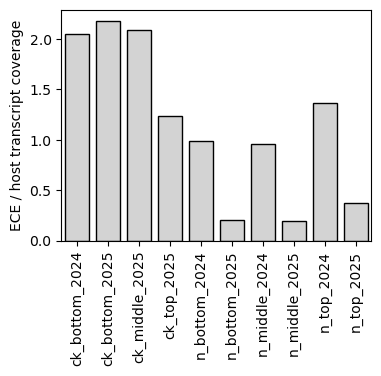

In [42]:
fig, ax = plt.subplots(figsize=(4, 3))

figure_df = list()
for sample_name, df in metat_summary_df[metat_summary_df.target_name.isin([ece_id, 'methanoperedens_2'])].groupby('sample_name'):
    ratio = df[df.target_name == ece_id].assigned_coverage.iloc[0] / df[df.target_name == 'methanoperedens_2'].assigned_coverage.iloc[0]
    figure_df.append({'sample_name':sample_name, 'ratio':ratio})
figure_df = pd.DataFrame(figure_df)

sns.barplot(figure_df, x='sample_name', y='ratio', color='lightgray', edgecolor='black')
ax.set_xticks(ax.get_xticks(), labels=ax.get_xticklabels(), rotation=90)
ax.set_xlabel('')
ax.set_ylabel('ECE / host transcript coverage')
plt.show()
# Want to compare the transcriptional activity of the host genome to the ECE. 
# Because we are doing intra-sample comparison, we are controlling for read depth. 

In [5]:
metat_df = metat_load()
metat_df = metat_df[~metat_df.target_name.isin(['ece_26_1334_all_orfs', 'ece_26_1334_rev'])].copy()
metat_df['id'] = [f'{target_name}_{gene_id}' for target_name, gene_id in zip(metat_df.target_name, metat_df.gene_id)]
metat_df = filter_low_counts(metat_df)

filter_low_counts: Keeping 1190 out of 5049 total genes.


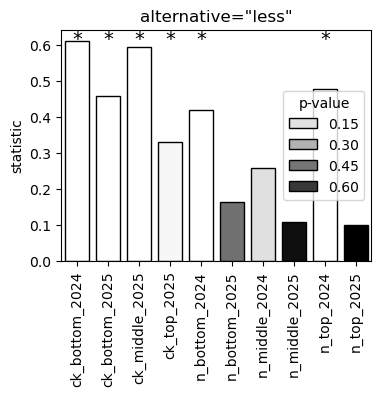

Sample ck_bottom_2024, p-value 2.021794600305932e-05
Sample ck_bottom_2025, p-value 0.0028711025004172154
Sample ck_middle_2025, p-value 4.069092109852796e-05
Sample ck_top_2025, p-value 0.048865483414361685
Sample n_bottom_2024, p-value 0.007624356625332471
Sample n_bottom_2025, p-value 0.46190686555443594
Sample n_middle_2024, p-value 0.15490856611576642
Sample n_middle_2025, p-value 0.6912710383137322
Sample n_top_2024, p-value 0.0016561128586856063
Sample n_top_2025, p-value 0.7285590196446738


In [8]:
# How does Methanoperedens metabolism change in each condition?
# Should I compare bottom to bottom and top to top?

# CLR is good for counts, because it assumes the input data is compositional. However, coverage is no longer compositional, as it
# controls for gene length. I think it is still the best option here, because I want to preserve the ratios. 

def get_clr_normalization(metat_df):
    # I think I want to normalize by genome and by sample in order to figure out differential regulation... 
    # assert metat_df.target_name.nunique() == 1, 'get_clr_normalization: Expected only one target genome in the DataFrame.'
    clr_mean = {sample_name:np.log(scipy.stats.gmean(df.coverage)) for sample_name, df in metat_df.groupby('sample_name')}
    metat_df['clr_mean'] = metat_df.sample_name.map(clr_mean)
    # Should not ba adding zero here, because it distorts the ratios. Instead, use multiplicative zero replacement, which keeps ratios of the nonzero elements the same.
    metat_df['normalized_coverage'] = np.log(metat_df.coverage) - metat_df.clr_mean
    return metat_df

host_metat_df = metat_df[metat_df.target_name == 'methanoperedens_2'].copy()
host_metat_df['nitrate'] = host_metat_df.sample_name.str.startswith('n_')
host_metat_df = get_clr_normalization(host_metat_df)

print(f'Num. unique genes: {host_metat_df['id'].nunique()}')

Num. unique genes: 649


In [9]:
ko_df = kegg_load('../data/kegg/methanoperedens_2.txt')
ko_df['target_name'] = 'methanoperedens_2'
# ko_df['id'] = [f'{target_name}_{gene_id}' for target_name, gene_id in zip(ko_df.target_name, ko_df['id'])]
ko_df = ko_df.sort_values('e_value').drop_duplicates('id')

host_df = GenBankFile.from_file('../data/methanoperedens_2.gbk').to_df()
# host_df['ko']
host_df['ko'] = host_df.index.map(ko_df.set_index('id').ko.to_dict())
host_df['ko_definition'] = host_df.index.map(ko_df.set_index('id').definition.to_dict())
host_df[['ko', 'ko_definition']] = host_df[['ko', 'ko_definition']].fillna('none')

In [10]:
pathways = dict()
pathways['map00680'] = 'methane metabolism'
pathways['map01310'] = 'nitrogen cycle  '
pathways['map00910'] = 'nitrogen metabolism'

def load_kos(pathway, kegg_dir='../data/kegg'):
    path = os.path.join(kegg_dir, f'{pathway}.tsv')
    df = pd.read_csv(path, sep='\t', names=['id', 'ko'])
    kos =  df.ko.values.tolist()
    kos = [ko.split(':')[-1] for ko in kos]
    return kos

map00910_kos = load_kos('map00910')
map00680_kos = load_kos('map00680')

print('Num. genes with a KO group:', ko_df['id'].nunique(), 'out of', host_metat_df['id'].nunique())
print('Num. KO groups:', ko_df['ko'].nunique())

Num. genes with a KO group: 1104 out of 649
Num. KO groups: 921


In [11]:
ko_to_pathway_map = kegg_get_pathways_by_ko(ko_df.ko.unique())
ko_to_module_map, module_to_ko_map = kegg_get_modules_by_ko(ko_df.ko.unique())
module_name_map = {module:kegg_get_module(module) for module in module_to_ko_map.keys()}

Explained variance: [0.3170193  0.24706355]


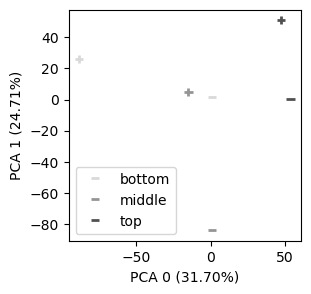

In [12]:
year = '2025'

# pca_df = host_metat_df[['nitrate', 'id', 'normalized_coverage', 'sample_name']].copy()
pca_df = host_metat_df[['nitrate', 'gene_id', 'normalized_coverage', 'sample_name']].copy()
pca_df = pca_df[pca_df.sample_name.str.contains(year)].copy()
pca_df = pca_df.pivot(columns='gene_id', values='normalized_coverage', index='sample_name')

values = pca_df.values 
# values = sklearn.preprocessing.StandardScaler().fit_transform(values)

pca = sklearn.decomposition.PCA(n_components=2)
pca.fit(values)

print(f'Explained variance: {pca.explained_variance_ratio_}')

components = pca.fit_transform(values).T

figure_df = pd.DataFrame(index=pca_df.index)
for i in range(len(components)):
    figure_df[f'pca_{i}'] = components[i]
figure_df['sample_name'] = figure_df.index
figure_df['nitrate'] = figure_df.index.str.startswith('n_')
figure_df['nitrate'] = np.where(figure_df.nitrate, '+', '-')

get_sample_location = lambda sample_name : re.search('top|bottom|middle', sample_name).group(0)
figure_df['location'] = figure_df.sample_name.apply(get_sample_location)

fig, ax = plt.subplots(figsize=(3, 3))
sns.scatterplot(figure_df[figure_df.nitrate == '+'], x='pca_0', y='pca_1', hue='location', palette='Grays', marker='+', linewidth=2, legend=False)
sns.scatterplot(figure_df[figure_df.nitrate == '-'], x='pca_0', y='pca_1', hue='location', palette='Grays', marker='_', linewidth=2, legend=True)
ax.get_legend().set_title('')
sns.move_legend(ax, loc='lower left')

ax.set_xlabel(f'PCA 0 ({pca.explained_variance_ratio_[0] * 100:.2f}%)')
ax.set_ylabel(f'PCA 1 ({pca.explained_variance_ratio_[1] * 100:.2f}%)')

plt.show()

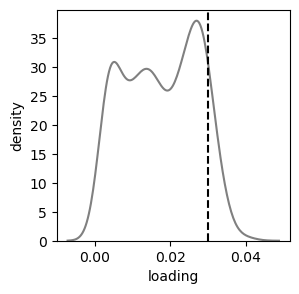

Num. features with importance > 0.03: 58


In [13]:
threshold = 0.03

loadings = pca.components_ # Components are the eigenvectors, which shape (n_components, n_features). Not sure why we need to take the absolute value?
# To get the feature importance, need the loadings scaled by the explained variance ratio (probably regular explained variance would also work)
loadings = np.abs(loadings) * pca.explained_variance_ratio_.reshape(-1, 1) # End up with a 1125 by 5 matrix; this is broadcasting, not matrix multiplication. 
loadings = loadings.sum(axis=0) # Get total importance of each feature. 

n_features = pca_df.shape[-1]
figure_df = pd.DataFrame(index=np.arange(n_features))
figure_df['gene_id'] = pca_df.columns 
figure_df['loading'] = loadings
figure_df['ko'] = figure_df['gene_id'].map(ko_df.set_index('id').ko)
figure_df['ko_name'] = figure_df['gene_id'].map(ko_df.set_index('id').definition)

fig, ax = plt.subplots(figsize=(3, 3))
sns.kdeplot(figure_df, x='loading', color='gray')
ax.set_ylabel('density')
ax.axvline(threshold, ls='--', color='black')
plt.show()
print(f'Num. features with importance > {threshold}:', (figure_df.loading > threshold).sum())
important_ids = figure_df[figure_df.loading > threshold].sort_values('loading')['gene_id'].unique()




In [14]:
# What am I going to use as a reference? Thinking about doing a heatmap with genes on the y-axis, and then each x-axis value is a measure in 
# a nitrate plus sample relative to one of the controls. 4 "controls",  "treatment groups." So 20 total comparisons to make. 
n_sample_names = metat_df.sample_name[metat_df.sample_name.str.startswith('n_')].unique()
ck_sample_names = metat_df.sample_name[~metat_df.sample_name.str.startswith('n_')].unique()


def get_differential_expression(metat_df:pd.DataFrame, control_sample_names=ck_sample_names, year='2025'):
    '''Limited by the fact that I don't have true technical replicates.'''
    # Each row is a gene and each column is the expression level of that gene in the sample.
    df = metat_df.pivot(columns='sample_name', values='normalized_coverage', index='gene_id').copy()
    df = df.reset_index()

    sample_names = [sample_name for sample_name in metat_df.sample_name.unique() if (sample_name not in control_sample_names)]

    diff_df = list()
    # for sample_name, control_sample_name in itertools.product(sample_names, control_sample_names):
    #     diff_df += [{'id':row['id'], 'delta':row[sample_name] - row[control_sample_name], 'control_sample_name':control_sample_name, 'sample_name':sample_name} for row in df.to_dict(orient='records')]
    for sample_name, control_sample_name in itertools.product(sample_names, control_sample_names):
        diff_df += [{'gene_id':row['gene_id'], 'delta':row[sample_name] - row[control_sample_name], 'control_sample_name':control_sample_name, 'sample_name':sample_name} for row in df.to_dict(orient='records')]
    diff_df = pd.DataFrame(diff_df)

    # Filter for samples from the same location, it seems like comparing middle to top, etc. does not really work. 
    get_sample_location = lambda sample_name : re.search('top|bottom|middle', sample_name).group(0)

    diff_df = diff_df[diff_df.control_sample_name.str.contains(year) & diff_df.sample_name.str.contains(year)].copy()
    diff_df = diff_df[diff_df.control_sample_name.apply(get_sample_location) == diff_df.sample_name.apply(get_sample_location)].copy()

    has_consistent_regulation = lambda df : np.all(np.sign(df.delta.values) == np.sign(df.delta.values)[0])
    diff_df['consistent'] = diff_df['gene_id'].map(diff_df.groupby('gene_id').apply(has_consistent_regulation, include_groups=False))
    
    return diff_df

host_diff_df = get_differential_expression(host_metat_df)


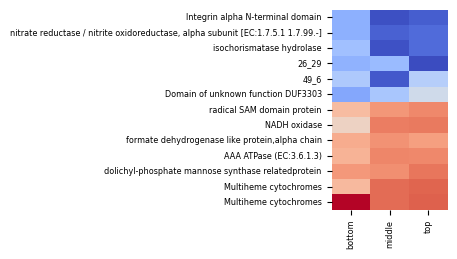

In [15]:
def pivot_differential_expression(diff_df, column_order=['n_bottom_2025', 'n_middle_2025', 'n_top_2025'], columns='sample'):
    diff_df = diff_df.pivot(columns='sample_name', values='delta', index='gene_id').copy()
    diff_df = diff_df[column_order].copy()
    return diff_df

control_sample_name_map = {control_sample_name:i for i, control_sample_name in enumerate(ck_sample_names)}

def plot_differential_expression(diff_df:pd.DataFrame, annotations:dict=None, ids=None):
    figure_df = diff_df.copy()

    figure_df = figure_df[figure_df['gene_id'].isin(ids)].copy() if (ids is not None) else figure_df
    figure_df = pivot_differential_expression(figure_df)

    ids = figure_df.index.copy()
    if annotations is not None:
        figure_df.index = figure_df.index.map(annotations)
        figure_df.index = np.where(figure_df.index.isnull(), ids, figure_df.index)

    figure_df['mean'] = figure_df.values.mean(axis=1).ravel()
    figure_df = figure_df.sort_values(by='mean') # Sort by the average delta across all samples.. 

    fig, ax = plt.subplots(figsize=(1.5, len(figure_df) / 5))
    sns.heatmap(figure_df.drop(columns='mean'), cmap='coolwarm', cbar=False, ax=ax)
    ax.set_yticks(np.arange(len(figure_df)) + 0.5, figure_df.index.values, fontsize='xx-small')
    ax.set_xticks(ax.get_xticks(), labels=['bottom', 'middle', 'top'], fontsize='xx-small')
    ax.set_xlabel('')
    ax.set_ylabel('')
    return ax , ids
    # plt.show()

annotations = ko_df.set_index('id')['definition'].to_dict()
annotations.update(host_df[~host_df['product'].str.contains('hypothetical|Tax=')]['product'].to_dict())
annotations['7_12'] = 'Domain of unknown function DUF3303' # Several members are annotated as being LysM domain-like proteins, but these did not match any LysM domains reported in the literature. 
annotations['22_21'] = 'NADH oxidase'
annotations['12_41'] = 'Integrin alpha N-terminal domain'
annotations['52_1'] = 'Multiheme cytochromes'
annotations['52_4'] = 'Multiheme cytochromes'

ax, ids = plot_differential_expression(host_diff_df[host_diff_df.consistent], ids=important_ids, annotations=annotations)
# ax = plot_differential_expression(host_diff_df[~host_diff_df.consistent], annotations=annotations, ids=important_ids)
plt.show()
# It seems likely that a lot of what PCA is capturing is the variance between locations, not between samples. 
# Values are the value in the treatment group (nitrate) minus the value in the control (no nitrate)

In [16]:
host_interpro_df = InterProScanFileTSV.from_file(f'../data/interproscan/methanoperedens_2.tsv').to_df()
host_interpro_df = host_interpro_df.sort_values(['id', 'e_value'])
host_interpro_df[host_interpro_df['id'].isin(['7_12', '12_41', '49_6', '26_29', '22_21', '52_1', '52_4'])]
host_interpro_df[host_interpro_df['id'].isin(ids)].sort_values('e_value').drop_duplicates('id')
# len(ids), len(host_interpro_df[host_interpro_df['id'].isin(ids)])

,id,md5,length,signature_analysis,signature_accession,signature_description,start,stop,e_value,status,date
2706,13_10,4515ca61b1223fbc7ea96473c76b0ad8,400,SFLD,SFLDG01072,dehydrogenase like,1,396,0.000000e+00,T,23-11-2025
11660,14_66,489704f17734f0d5ef54b7f6b10707c8,941,CDD,cd02750,MopB_Nitrate-R-NarG-like,84,796,0.000000e+00,T,23-11-2025
669,4_49,b2f60d38115b11b7982e3607f3b527c2,735,NCBIfam,TIGR01243,CDC48 family AAA ATPase,5,713,0.000000e+00,T,23-11-2025
5220,19_60,5fcc05d7b385ff4dcb47a9194fd11e2e,222,PANTHER,PTHR43559,HYDROLASE YCAC-RELATED,13,219,5.000000e-86,T,23-11-2025
5663,8_36,d0f4942a4af57ccde9114950d43387b2,299,FunFam,G3DSA:3.90.550.10:FF:000129,Glycosyltransferase family 2 protein,1,223,1.000000e-76,T,23-11-2025
5488,22_21,fcfb6b1a69e05b570288a2ac5c68560e,236,Gene3D,G3DSA:3.40.109.10,NADH Oxidase,1,235,1.200000e-36,T,23-11-2025
11789,32_14,6681d11ae2253c4fdcc3e2d4987038fe,489,SUPERFAMILY,SSF53706,"Formate dehydrogenase/DMSO reductase, domains 1-3",3,342,1.080000e-28,T,23-11-2025
10665,52_4,22be48323bfd619700a87f85e065c5d1,322,SUPERFAMILY,SSF48695,Multiheme cytochromes,19,226,3.260000e-20,T,23-11-2025
11240,52_1,db072d9ed087e2ab1f73db5eaf7bec8f,557,SUPERFAMILY,SSF48695,Multiheme cytochromes,98,552,1.320000e-17,T,23-11-2025
5644,12_41,34763aeec84e8a02ab1c0dabc063e950,625,SUPERFAMILY,SSF69318,Integrin alpha N-terminal domain,365,600,5.490000e-16,T,23-11-2025


In [17]:
def get_overlaps(id_:str, remove_ids:list=[f'1_{i}' for i in range(39, 67)]):
    cols = ['contig_id', 'model', 'feature_type', 'start', 'stop', 'score', 'strand', 'phase', 'id']
    kwargs = {'sep':'\t', 'comment':'#', 'names':cols}
    ece_df = pd.concat([pd.read_csv(f'../data/{ece_id}.gff', **kwargs), pd.read_csv(f'../data/{ece_id}_all_orfs.gff', **kwargs)])

    ece_df = ece_df[~ece_df.index.duplicated()].copy()
    ece_df = ece_df[~ece_df.index.isin(remove_ids)].copy()
    ece_df['id'] = ece_df['id'].str.replace('ID=', '')
    ece_df = ece_df.set_index('id')

    start, stop = ece_df.loc[id_].start, ece_df.loc[id_].stop 
    df = ece_df[~((ece_df.start >= stop) | (ece_df.stop <= start))].copy()
    df = df[df.index != id_].copy()
    return df.index.tolist()

filter_low_counts: Keeping 1797 out of 5202 total genes.


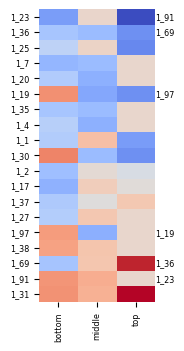

In [18]:
# Also want to look at the differential regulation of the ECE genes. 
metat_df = metat_load()
metat_df['id'] = [f'{target_name}_{gene_id}' for target_name, gene_id in zip(metat_df.target_name, metat_df.gene_id)]
metat_df = filter_low_counts(metat_df, min_count=3)

# A lot of the all_orfs IDs are heavily-overlapping, and I don't want things to get obscured.
# They might look transcribed just because one of the overlapping genes is transcribed.
ece_remove_gene_ids = [f'1_{i}' for i in range(39, 67)]
metat_df = metat_df[~metat_df.gene_id.isin(ece_remove_gene_ids)].copy()

ece_metat_df = metat_df[metat_df.target_name.isin([ece_id, f'{ece_id}_all_orfs'])].copy() # Should include the weird ones on the opposite strand. 
ece_metat_df = ece_metat_df.drop_duplicates(['sample_name', 'gene_id'])
ece_metat_df = get_clr_normalization(ece_metat_df)
ece_diff_df = get_differential_expression(ece_metat_df)


# plot_differential_expression(ece_diff_df[ece_diff_df.consistent], consistent_regulation=False)
# plot_differential_expression(ece_diff_df[~ece_diff_df.consistent], consistent_regulation=False)
ax, _ = plot_differential_expression(ece_diff_df)

x_max = ax.get_xlim()[-1]
for label, y_tick in zip(ax.get_yticklabels(), ax.get_yticks()):
    overlap_gene_ids = get_overlaps(label.get_text())
    overlap_gene_ids = [gene_id for gene_id in overlap_gene_ids if (gene_id in ece_diff_df.gene_id.values)] # Filter for ORFs with transcription data. 
    ax.text(x_max, y_tick, ', '.join(overlap_gene_ids), fontsize='xx-small', va='center')
plt.show()

# DNA polymerase is 1_20, which seems like it may be down-regulated in high-nitrate conditions.
# Potential transcription factors are 1_1, 1_12, 1_17, 1_32


In [19]:
# And the absolute regulation of the ECE genes in each condition, as well as transcription from the reverse strand.  
metat_df = metat_load()
metat_df['id'] = [f'{target_name}_{gene_id}' for target_name, gene_id in zip(metat_df.target_name, metat_df.gene_id)]
metat_df = filter_low_counts(metat_df, min_count=3)

ece_metat_df = metat_df[metat_df.target_name.isin([ece_id, f'{ece_id}_rev'])].copy() # Should include the weird ones on the opposite strand. 
ece_metat_df = ece_metat_df.drop_duplicates(['target_name', 'sample_name', 'gene_id'])
# ece_metat_df = get_clr_normalization(ece_metat_df)
ece_metat_df['reversed'] = ece_metat_df.target_name.str.contains('rev')

filter_low_counts: Keeping 1797 out of 5202 total genes.


Num. ECE genes which are expressed: 16
Num. ECE genes which are expressed on the opposite strand: 10
Num. ECE genes which are expressed on the both strands: 10


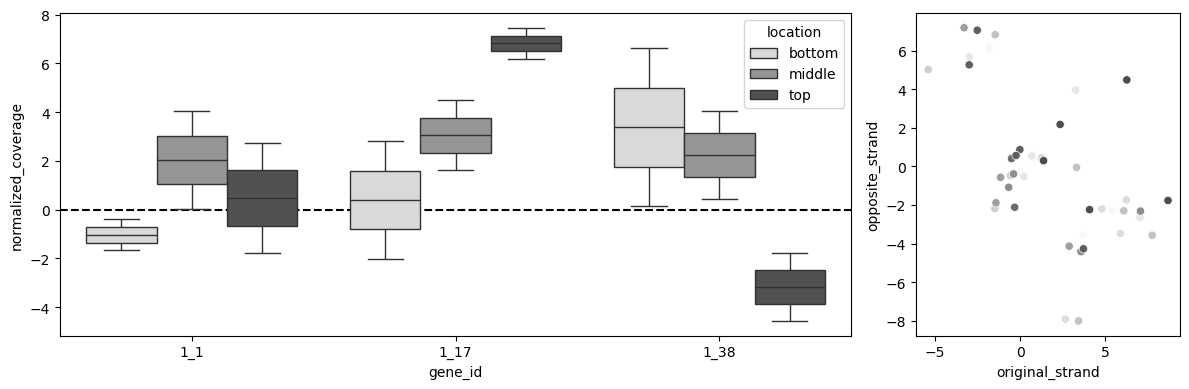

In [20]:
fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(12, 4), width_ratios=[0.75, 0.25])

print('Num. ECE genes which are expressed:', ece_metat_df[~ece_metat_df.reversed].gene_id.nunique())
print('Num. ECE genes which are expressed on the opposite strand:', ece_metat_df[ece_metat_df.reversed].gene_id.nunique())
ids = np.intersect1d(ece_metat_df[ece_metat_df.reversed].gene_id.unique(), ece_metat_df[~ece_metat_df.reversed].gene_id.unique())
print('Num. ECE genes which are expressed on the both strands:', len(ids))

figure_df = ece_metat_df.copy()
figure_df = figure_df[figure_df.sample_name.str.contains('2025')].copy()
figure_df['nitrate'] = figure_df.sample_name.str.startswith('n')
get_sample_location = lambda sample_name : re.search('top|bottom|middle', sample_name).group(0)
figure_df['location'] = figure_df.sample_name.apply(get_sample_location)


transcription_factor_ids = ['1_1', '1_12', '1_17', '1_32', '1_38']

ax_df = figure_df[~figure_df.reversed].copy()
ax_df = get_clr_normalization(ax_df)
ax_df = ax_df[ax_df.gene_id.isin(transcription_factor_ids)].copy()
ax_a.axhline(0, color='black', ls='--')
# sns.boxplot(ax_df, x='gene_id', y='normalized_coverage', ax=ax_a, color='lightgray', showfliers=False)
sns.boxplot(ax_df, x='gene_id', y='normalized_coverage', ax=ax_a, palette='Grays', hue='location', showfliers=False)
# sns.stripplot(ax_df, x='gene_id', y='normalized_coverage', ax=ax_a, color='gray', s=3)


# ax_df = ax_df[]
ax_df = get_clr_normalization(figure_df)
ax_df['reversed'] = np.where(ax_df.reversed, 'opposite_strand', 'original_strand')
ax_df['id'] = [f'{row.sample_name}_{row.gene_id}' for row in ax_df.itertuples()]
remove_ids = ax_df.groupby('id').apply(lambda df : np.all(df.read_count_original == 0), include_groups=False)
remove_ids = remove_ids[remove_ids].index.values

ax_df = ax_df[~ax_df['id'].isin(remove_ids)]
ax_df = ax_df.pivot(columns='reversed', index=['gene_id', 'sample_name'], values='normalized_coverage')
ax_df = ax_df.reset_index(drop=False)

# ids = ['1_2', '1_17', '1_19', '1_23', '1_30', '1_31', '1_37', '1_38']
sns.scatterplot(ax_df, x='original_strand', y='opposite_strand', hue='gene_id', legend=False, palette='Grays')
# ax_b.set_yscale('log')
# ax_b.set_xscale('log')
fig.tight_layout()
plt.show()

# Using the normalized coverage could be problematic due to the fact that an overall decrease in the expression of ECE genes could look like
# an increase in the expression of a particular gene, so need to be careful about what we can say from this. 

In [21]:
remove_gene_ids

NameError: name 'remove_gene_ids' is not defined

In [ ]:

# Want to see which genes the expression profiles most correlate with, perhaps. Best way to do this might be PCA, though there are
# only three features, so might be iffy. Probably better to just do correlation directly. 
def get_correlated_expressions(ece_diff_df:pd.DataFrame, host_diff_df:pd.DataFrame):
    ece_diff_df = pivot_differential_expression(ece_diff_df)
    host_diff_df = pivot_differential_expression(host_diff_df)

    corr_df = pd.DataFrame(index=ece_diff_df.index, columns=host_diff_df.index)
    for ece_values in ece_diff_df.itertuples():
        for host_values in host_diff_df.itertuples():
            r = np.corrcoef(ece_values[1:], host_values[1:])[0][1]
            corr_df.loc[ece_values[0], host_values[0]] = r ** 2
    return corr_df

corr_df = get_correlated_expressions(ece_diff_df, host_diff_df)

In [ ]:
# corr_expression = dict()
# threshold = 0.95

# fig, ax = plt.subplots(figsize=(4, 4))
# for row in corr_df.itertuples():
#     values = np.array(list(row[1:]))
#     corr_expression[row[0]] =  corr_df.columns.to_numpy()[values > threshold].tolist()
#     sns.kdeplot(values, color='gray', alpha=0.5, ax=ax)

# ax.set_ylabel('density')
# ax.set_xlim(xmin=0, xmax=1)
# ax.axvline(threshold, lw=0.7, color='black', ls='--')
# plt.show()

In [43]:
# # Characterize patterns across samples with Kolmogorov-Smirnov test. If one-sided, it will q
# fig, ax = plt.subplots(figsize=(4, 3))

# # We are testing to see if the ECE transciption is greater than the host, with the null being that it is less than the host. 
# # For alternative='greater': The null hypothesis is that F(x) <= G(x) for all x; the alternative is that F(x) > G(x) for at least one x.

# alternative = 'two-sided'
# alternative = 'less'
# get_ks_result = lambda df : scipy.stats.kstest(df[~df.host].normalized_coverage.values, df[df.host].normalized_coverage.values, alternative=alternative)

# ax_df = pd.DataFrame(index=pd.Series(figure_df.sample_name.unique(), name='sample_name'))
# ax_df['p_value'] = figure_df.groupby('sample_name').apply(lambda df : get_ks_result(df).pvalue, include_groups=False)
# ax_df['statistic'] = figure_df.groupby('sample_name').apply(lambda df : get_ks_result(df).statistic, include_groups=False)
# signficant_samples = ax_df.index[ax_df.p_value < 0.05].values

# ax_df = ax_df.sort_values('sample_name')
# sns.barplot(ax_df, x='sample_name', y='statistic', hue='p_value', palette='Grays', edgecolor='black')
# ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)

# for x, label in zip(ax.get_xticks(), ax.get_xticklabels()):
#     if label.get_text() in signficant_samples:
#         ax.text(x, ax.get_ylim()[-1], '*', ha='center', va='top', fontsize=14)

# ax.set_xlabel('')
# ax.get_legend().set_title('p-value')
# ax.set_title(f'alternative="{alternative}"')
# plt.show()

# for row in ax_df.itertuples():
#     print(f'Sample {row.Index}, p-value {row.p_value}')

# # There are a couple of explanations for the patterns here. Firstly, it could be that the relative copy number of host to ECE changes, 
# # in which case the changes in transcription could be caused by an increase in the number of ECE per cell (plausible considering the plot above, 
# # also unclear if there are potentially other hosts in the environment). Or, more interestingly, the Methanoperedens which are able to survive in 
# # the low-nitrate conditions preferentially have the ECE. 

# # Another possible reason is that the general level of host activity has decreased, resulting in a higher CLR mean. However, 
# # this would imply that the transcriptional activity of the ECE has changed by less. 

# # To me, because ECE genes are likely transcribed by host transcription machinery, it seems most likely that ECE genes would be specifically 
# # up-regulated. I would expect a general decrease in host transcriptional activity to coincide with a decrease in ECE activity as well, 
# # simply because the same proteins are being used. Not sure if there is any precedence for a systemic decrease in host transcription resulting in 
# # a relative increase in host transcription. 

In [ ]:
# df = host_metat_df.pivot(columns='sample_name', values='normalized_coverage', index='id').copy()
# # df.columns = df.columns.get_level_values(1)
# df = df.reset_index()

# n_sample_names = host_metat_df.sample_name[host_metat_df.sample_name.str.startswith('n_')].unique()
# ck_sample_names = host_metat_df.sample_name[~host_metat_df.sample_name.str.startswith('n_')].unique()

# diff_df = list()
# for n_sample_name, ck_sample_name in itertools.product(n_sample_names, ck_sample_names):
#     # diff_df += [{'id':row['id'], 'diff':row[n_sample_name] - row[ck_sample_name], 'ck_sample_name':ck_sample_name, 'n_sample_name':n_sample_name} for row in df.to_dict(orient='records')]
# diff_df = pd.DataFrame(diff_df)

# # Perhaps shouldn't trust the genes with a high degree of variance in their differential expression. 

# # ChaTGPT suggested using median absolute deviation instead, which is more robust to outliers. 
# # Could take two approaches: remove outlier samples, or just remove entire genes. 

# # MAD score on its own does not capture directional consistency, which is resulting in poor filtering. 
# # Also want to make sure that the majority of samples have the same sign, i.e. a gene is either up- or down- regulated, not both. 
# is_consistently_regulated = lambda df : np.all(np.sign(df['diff'].values) == np.sign(df['diff'].values)[0])
# threshold = 0.7
# is_consistently_regulated = lambda df : (np.sign(df['diff'].values) == np.sign(df['diff'].values)[0]).mean() > threshold
                                       
# # First compute the mean absolute deviation for a given sample, which is essentially the median of the difference between the values and the median. 
# diff_df['sample_median'] = diff_df['id'].map(diff_df.groupby('id')['diff'].median())
# diff_df['consistently_regulated'] = diff_df['id'].map(diff_df.groupby('id').apply(is_consistently_regulated, include_groups=False))
# diff_df['diff_minus_sample_median'] = np.abs(diff_df['diff'] - diff_df.sample_median)
# diff_df['median_absolute_deviation'] = diff_df['id'].map(diff_df.groupby('id').diff_minus_sample_median.median())
# diff_df['median_absolute_deviation_z_score'] = diff_df.diff_minus_sample_median / diff_df.median_absolute_deviation
# diff_df['std'] = diff_df['id'].map(diff_df.groupby('id')['diff'].std())

# threshold = 3
# # print('Num. genes with the standard deviation exceeding the threshold:', diff_df[(diff_df['std'] > threshold)]['id'].nunique())
# print('Num. total genes:', diff_df['id'].nunique())
# print('Num. values with the MAD score exceeding the threshold:', (diff_df.median_absolute_deviation_z_score > threshold).sum())
# print('Num. genes with the MAD score exceeding the threshold in at least one sample:', diff_df[diff_df.median_absolute_deviation_z_score > threshold]['id'].nunique())

# variable_ids = diff_df[(diff_df.median_absolute_deviation_z_score > threshold)]['id'].unique().tolist()
# variable_ids += diff_df[~diff_df.consistently_regulated]['id'].unique().tolist()

# mask = ~diff_df['id'].isin(variable_ids)
# print('Num. samples removed:', (~mask).sum(), 'out of', len(diff_df))
# # diff_df = diff_df[diff_df.median_absolute_deviation_z_score <= threshold].copy()
# diff_df = diff_df[mask].copy()

In [ ]:
# fig, ax = plt.subplots(figsize=(4, 4))

# upregulated_threshold = 3
# downregulated_threshold = -3

# diff_df['upregulated'] = diff_df['diff'] > upregulated_threshold
# diff_df['downregulated'] = diff_df['diff'] < downregulated_threshold
# diff_df['ko'] = diff_df['id'].map(kegg_df.sort_values('e_value').drop_duplicates('id').set_index('id').ko)
# diff_df['module'] = diff_df.ko.map({ko:map_[0] for ko, map_ in ko_to_module_map.items()}) # Just get the first module for now. 
# diff_df['module_description'] = diff_df.module.map(module_name_map)
# diff_df['ko_description'] = diff_df.ko.map(ko_name_map)
# diff_df['regulation'] = np.select([diff_df.upregulated, diff_df.downregulated], ['+', '-'], default='.')
# diff_df = diff_df.fillna('none')

# upregulated_ids = diff_df[diff_df.upregulated]['id'].unique()
# downregulated_ids = diff_df[diff_df.downregulated]['id'].unique()
# assert len(np.intersect1d(upregulated_ids, downregulated_ids)), 'There are genes marked as both significantly up- and down- regulated.'

# print('Num. genes upregulated:', len(upregulated_ids))
# print('Num. genes downregulated:', len(downregulated_ids))

# sns.kdeplot(diff_df, x='diff', color='gray')
# ax.set_ylabel('density')
# plt.show()

In [ ]:
# # Some Kegg Ortho groups are not associated with pathways. 
# upregulated_pathways = [pathway for ko in diff_df[diff_df.upregulated].ko.dropna().unique() if (ko in ko_to_pathway_map) for pathway in ko_to_pathway_map[ko]]
# downregulated_pathways = [pathway for ko in diff_df[diff_df.downregulated].ko.dropna().unique() if (ko in ko_to_pathway_map) for pathway in ko_to_pathway_map[ko]]

# # upregulated_modules = [mod for ko in diff_df[diff_df.upregulated].ko.dropna().unique() if (ko in ko_to_module_map) for mod in ko_to_module_map[ko]]
# # downregulated_modules = [mod for ko in diff_df[diff_df.downregulated].ko.dropna().unique() if (ko in ko_to_module_map) for mod in ko_to_module_map[ko]]
# upregulated_modules = [ko_to_module_map[ko][0] for ko in diff_df[diff_df.upregulated].ko.dropna().unique() if (ko in ko_to_module_map)]
# downregulated_modules = [ko_to_module_map[ko][0] for ko in diff_df[diff_df.downregulated].ko.dropna().unique() if (ko in ko_to_module_map)]

# min_count = 1
# figure_df = [{'module':mod, 'category':'upregulated'} for mod in upregulated_modules]
# figure_df += [{'module':mod, 'category':'downregulated'} for mod in downregulated_modules]
# figure_df = pd.DataFrame(figure_df)
# # figure_df = figure_df[figure_df.module.str.startswith('map')].copy()
# figure_df = figure_df[figure_df.module.str.startswith('M')].copy()
# figure_df['count'] = figure_df.module.map(figure_df.module.value_counts())
# figure_df = figure_df[figure_df['count'] > min_count].copy()

# fig, ax = plt.subplots(figsize=(10, 4))
 
# sns.histplot(figure_df, x='module', hue='category', multiple='dodge', palette='Grays')
# labels = [module_name_map[module.get_text()] for module in ax.get_xticklabels()]
# labels = [label.split(',')[0] for label in labels]
# ax.set_xticks(ax.get_xticks(), labels, rotation=90)
# ax.set_xlabel('')
# ax.get_legend().set_title('')
# plt.show()

In [ ]:
# # First want to compare the Methanoperedens read counts and ECE read counts across samples. 

# figure_df = list()

# for sample_name, df in metat_df.groupby('sample_name'):
#     for i in range(1, 3):
#         row = {'methanoperedens_id':i, 'sample_name':sample_name}
#         row['Methanoperedens'] = df[df.target_name == f'methanoperedens_{i}'].coverage.mean()
#         row['ECE'] = df[df.target_name == ece_id].coverage.mean()
#         figure_df.append(row)
# figure_df = figure_df[figure_df.methanoperedens_id == 2].copy() # values for 2 are consistently higher, maybe the genome is more complete. 
# figure_df = pd.DataFrame(figure_df)
# # figure_df = figure_df[figure_df.sample_name.str.startswith('n')].copy() # Nitrate samples only, for now. 
# # figure_df['sample_location'] = [re.search('top')]

# sns.scatterplot(figure_df, x='ECE', y='Methanoperedens', legend=True, hue='methanoperedens_id')
# # sns.scatterplot(figure_df, x='ECE', y='Methanoperedens', hue='methanoperedens_id', legend=False, palette={1:'gray', 2:'darkgray'})


In [ ]:
# figure_df = metat_df.copy()
# figure_df['category'] = np.where(metat_df.target_name.str.contains('methanoperedens'), 'host', 'ECE')

# for sample_name, df in figure_df.groupby('sample_name'):
#     print(f'Percentage of genes with no mapped reads in sample {sample_name}: {100 * (df.coverage == 0).sum() / len(df):.2f}%')
# # figure_df = figure_df[figure_df.coverage > 0].copy()

# fig, axes = plt.subplots()
# sns.ecdfplot(figure_df, x='coverage', hue='sample_name', palette='Grays')
# ax.set_xlim(xmin=0, xmax=5)

# # How to go about normalizing this? Differences in ECE and Methanoperedens read counts might be related to differing numbers of each group 
# # in the sample

In [ ]:
# This is just a more complicated and difficult-to-explain version of the analysis above. 

# # Despite being about 10 times more abundant than the host genome in the samples, the transcript activity on the ECE is similar to that of 
# # most of the host genes. Not completely sure how to rationalize this. Perhaps implies that there is a lot that's not actually associated with a cell?

# figure_df = metat_df.copy()
# figure_df = figure_df[figure_df.target_name.isin([ece_id, 'methanoperedens_2'])].copy() # More reads map to the second genome, and I think it is more complete. 
# figure_df['host'] = figure_df.target_name != ece_id

# # I need to normalize the data somehow to facilitate comparison across samples. Using the Methanoperedens transcript data from each sample as a way
# # to normalize, which involves using the assumption that Methanoperedens versus ECE abundance is relatively fixed across samples. 
# clr_mean = {sample_name:np.log(scipy.stats.gmean(df[df.host].coverage)) for sample_name, df in figure_df.groupby('sample_name')}
# figure_df['clr_mean'] = figure_df.sample_name.map(clr_mean)
# figure_df['normalized_coverage'] = np.log(figure_df.coverage) - figure_df.clr_mean

# def plot_coverage_ecdf(figure_df, ax=plt.Axes, year='2025', nutrients='ck_'):
#     sample_names = [sample_name for sample_name in figure_df.sample_name.unique() if year in sample_name]
#     sample_names = [sample_name for sample_name in sample_names if nutrients in sample_name]
#     figure_df['sample'] = figure_df['sample_name']

#     sns.ecdfplot(figure_df[(figure_df.host) & (figure_df.sample_name.isin(sample_names))], x='normalized_coverage', color='lightgray', hue='sample', ls=':', palette='Grays', ax=ax)
#     sns.ecdfplot(figure_df[(~figure_df.host) & (figure_df.sample_name.isin(sample_names))], x='normalized_coverage', hue='sample', palette='Grays', ax=ax)
#     # ax.set_xlim(xmin=-1, xmax=3)
#     # ax.set_ylim(ymin=0)
#     # ax.get_legend().set_title('')
#     ax.set_ylabel('proportion')
#     ax.set_xlabel('normalized coverage (CLR)')

# fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

# plot_coverage_ecdf(figure_df, ax=axes[0], nutrients='ck_')
# plot_coverage_ecdf(figure_df, ax=axes[1], nutrients='n_')

# fig.tight_layout()
# plt.show()
